In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !unzip "/content/drive/My Drive/Celestine/Sequence_based FER/dataset.zip" -d "/content/drive/My Drive/Celestine/Sequence_based FER/dataset"


In [3]:
import os

# Set CUDA_LAUNCH_BLOCKING to 1
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

print("CUDA_LAUNCH_BLOCKING:", os.getenv('CUDA_LAUNCH_BLOCKING'))


CUDA_LAUNCH_BLOCKING: 1


In [4]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [5]:
import os
folder_path = '/content/drive/My Drive/Celestine/Sequence_based FER/saved_model'

os.makedirs(folder_path, exist_ok=True)

In [6]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from random import shuffle

import pandas as pd

import pickle

from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,ExtraTreesClassifier
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing

#from scipy.misc import imread, imresize

%matplotlib inline

In [7]:

INPUT_SIZE = (224, 224)

In [8]:
import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm


print(f"Torch: {torch.__version__}")

Torch: 2.2.1+cu121


In [9]:
print(torch.cuda.is_available())

True


In [10]:
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'
print(use_cuda,device)

True cuda


In [11]:
torch.cuda.empty_cache()  # Clear unused memory

In [12]:
USE_ENET2=False #True #

In [13]:
IMG_SIZE=260 if USE_ENET2 else 224 # 300 # 80 #
train_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)
print(test_transforms)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [14]:
# Download and set path to this model enet_b0_8_va_mtl.pt
# PATH="enet_b2_8_best.pt"
# PATH="enet_b0_8_best_afew.pt"
PATH="/content/drive/MyDrive/Celestine/Sequence_based FER/enet_b0_8_va_mtl.pt"
model_name='enet0_8_pt'

In [15]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [16]:
print(PATH)
model=torch.load(PATH, map_location=torch.device(device))
model.eval()
model=model.eval()

/content/drive/MyDrive/Celestine/Sequence_based FER/enet_b0_8_va_mtl.pt


In [17]:
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.compat.v1.Session(config=config)
set_session(sess)

In [18]:
# IMPORTANT


import os
import json
import torch
from torch.utils.data import Dataset
from PIL import Image

import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import json

class AFEWVADataset(Dataset):
    def __init__(self, root_dir, sequence_length, transform=None):
        self.root_dir = root_dir
        self.sequence_length = sequence_length
        self.transform = transform
        self.samples = []
        self._load_dataset()

    def _load_dataset(self):
        for main_folder in os.listdir(self.root_dir):
            main_folder_path = os.path.join(self.root_dir, main_folder)
            if os.path.isdir(main_folder_path):
                for video_folder in os.listdir(main_folder_path):
                    video_folder_path = os.path.join(main_folder_path, video_folder)
                    annotation_file = os.path.join(video_folder_path, 'labeled_data.json')
                    if os.path.isfile(annotation_file):
                        with open(annotation_file, 'r') as file:
                            annotations = json.load(file)
                        annotations_dict = {a['frame_id']: a for a in annotations}
                        frame_files = [f for f in os.listdir(video_folder_path) if f.startswith('face_') and f.endswith('.png')]
                        frame_files = sorted(frame_files, key=lambda x: int(x.split('_')[1].split('.')[0]))
                        if len(frame_files) >= self.sequence_length:
                            for i in range(len(frame_files) - self.sequence_length + 1):
                                sequence_frames = frame_files[i:i + self.sequence_length]
                                sequence_paths = [os.path.join(video_folder_path, f) for f in sequence_frames]
                                arousal_scores = [annotations_dict[f.split('_')[1].split('.')[0]]['arousal'] for f in sequence_frames]
                                valence_scores = [annotations_dict[f.split('_')[1].split('.')[0]]['valence'] for f in sequence_frames]

                                avg_arousal = round(sum(arousal_scores) / len(arousal_scores))
                                avg_valence = round(sum(valence_scores) / len(valence_scores))

                                # Convert to classes: map [-10, 10] to [0, 20]
                                arousal_class = int(avg_arousal) + 10
                                valence_class = int(avg_valence) + 10

                                self.samples.append((sequence_paths, arousal_class, valence_class))

    def __getitem__(self, idx):
        frame_paths, arousal_class, valence_class = self.samples[idx]
        frames = [self.transform(Image.open(fp).convert('RGB')) if self.transform else Image.open(fp).convert('RGB') for fp in frame_paths]
        frames_tensor = torch.stack(frames)
        return frames_tensor, arousal_class, valence_class

    def __len__(self):
        return len(self.samples)







# Define transformations and instantiate dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# dataset_path = r"C:\dataset\dataset"
dataset_path = '/content/drive/My Drive/Celestine/Sequence_based FER/dataset/dataset'
full_dataset = AFEWVADataset(root_dir=dataset_path, sequence_length=30, transform=transform)


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
original_model = torch.load(PATH, map_location=device)

In [20]:
import torch
import torch.nn as nn

class EfficientNetLSTM(nn.Module):
    def __init__(self, original_model, hidden_dim, lstm_layers):
        super(EfficientNetLSTM, self).__init__()
        self.efficient_net = original_model
        self.efficient_net.classifier = nn.Identity()
        self.lstm = nn.LSTM(1280, hidden_dim, num_layers=lstm_layers, batch_first=True)
        self.classifier_arousal = nn.Linear(hidden_dim, 21)  # 21 classes for arousal
        self.classifier_valence = nn.Linear(hidden_dim, 21)  # 21 classes for valence

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        c_out = torch.empty((batch_size, timesteps, 1280), device=x.device)

        for i in range(timesteps):
            frame_features = self.efficient_net(x[:, i, :, :, :])
            c_out[:, i, :] = frame_features.view(frame_features.size(0), -1)

        h_out, _ = self.lstm(c_out)
        h_out = h_out[:, -1, :]  # Using only the last timestep output for prediction
        output_arousal = self.classifier_arousal(h_out)
        output_valence = self.classifier_valence(h_out)
        return output_arousal, output_valence



In [21]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device=torch.device("cpu")
model = EfficientNetLSTM(original_model, 256, 2).to(device)
criterion = nn.CrossEntropyLoss()  # Suitable for classification with integer labels
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_one_epoch(model, train_loader, device, optimizer, criterion):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for sequences, arousal, valence in train_loader:
        sequences = sequences.to(device)
        arousal_labels = arousal.to(device)
        valence_labels = valence.to(device)


        assert torch.all(arousal_labels >= 0) and torch.all(arousal_labels < 21), "Arousal labels out of range"
        assert torch.all(valence_labels >= 0) and torch.all(valence_labels < 21), "Valence labels out of range"

        optimizer.zero_grad()
        outputs_arousal, outputs_valence = model(sequences)
        assert not torch.any(torch.isnan(outputs_arousal)), "NaNs in arousal outputs"
        assert not torch.any(torch.isnan(outputs_valence)), "NaNs in valence outputs"

        loss_arousal = criterion(outputs_arousal, arousal_labels)
        loss_valence = criterion(outputs_valence, valence_labels)
        loss = loss_arousal + loss_valence  # Combining losses for backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted_arousal = outputs_arousal.max(1)
        _, predicted_valence = outputs_valence.max(1)
        total_correct += (predicted_arousal == arousal_labels).sum().item()
        total_correct += (predicted_valence == valence_labels).sum().item()
        total_samples += arousal_labels.size(0) + valence_labels.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

def validate(model, val_loader, device, criterion):
    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_samples = 0

    with torch.no_grad():
        for sequences, arousal, valence in val_loader:
            sequences = sequences.to(device)
            arousal_labels = arousal.to(device)
            valence_labels = valence.to(device)

            assert torch.all(arousal_labels >= 0) and torch.all(arousal_labels < 21), "Arousal labels out of range"
            assert torch.all(valence_labels >= 0) and torch.all(valence_labels < 21), "Valence labels out of range"

            outputs_arousal, outputs_valence = model(sequences)
            assert not torch.any(torch.isnan(outputs_arousal)), "NaNs in arousal outputs"
            assert not torch.any(torch.isnan(outputs_valence)), "NaNs in valence outputs"
            loss_arousal = criterion(outputs_arousal, arousal_labels)
            loss_valence = criterion(outputs_valence, valence_labels)
            loss = loss_arousal + loss_valence
            total_val_loss += loss.item()

            _, predicted_arousal = outputs_arousal.max(1)
            _, predicted_valence = outputs_valence.max(1)
            total_val_correct += (predicted_arousal == arousal_labels).sum().item()
            total_val_correct += (predicted_valence == valence_labels).sum().item()
            total_val_samples += arousal_labels.size(0) + valence_labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = total_val_correct / total_val_samples
    return avg_val_loss, val_accuracy


Dataset setup for actual training and validation. We are using half of the entire dataset.

In [22]:
from torch.utils.data import DataLoader, random_split, Subset
# Use half of the dataset
total_size = len(full_dataset)
half_dataset_size = total_size // 2  # Use integer division to get half of the total size

# Generate indices for the first half of the dataset
indices = list(range(half_dataset_size))

# Split indices into train and test sets
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)  # 80% train, 20% test of the half dataset

# Split train indices further to create a validation set
train_indices, val_indices = train_test_split(train_indices, test_size=0.25, random_state=42)  # Of the 80% train, split into 60% train, 20% validation

# Create data subsets using the indices
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

# Outputs the sizes to confirm the splits
print(f"Total dataset: {total_size}")
print(f"Total dataset used: {half_dataset_size}")
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Create data loaders
batch_size = 8
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

Total dataset: 5525
Total dataset used: 2762
Training dataset size: 1656
Validation dataset size: 553
Test dataset size: 553


### To save files and sessions

In [23]:

path = '/content/drive/My Drive/Celestine/Sequence_based FER/'

def save_to_drive(filename, data):
    np.save(f'{path}{filename}.npy', data)

def save_checkpoint(model, optimizer, epoch, loss, filename):
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(state, f'{path}{filename}.pth')

In [24]:
num_epochs = 30


import time
best_val_loss = float('inf')
patience = 5
trigger_times = 0
train_losses = np.zeros(num_epochs)
val_losses = np.zeros(num_epochs)
train_accs = np.zeros(num_epochs)
val_accs = np.zeros(num_epochs)


for epoch in tqdm(range(num_epochs)):
    start_time = time.time()
    train_loss, train_accuracy = train_one_epoch(model, train_loader, device, optimizer, criterion)
    val_loss, val_accuracy = validate(model, val_loader, device, criterion)
    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss
    train_accs[epoch] = train_accuracy
    val_accs[epoch] = val_accuracy

    if epoch % 5 == 0:
        save_checkpoint(model, optimizer, epoch, val_loss, 'EfficientNetLSTM_checkpoint')

    epoch_time = time.time() - start_time

    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
    print(f'Time elapsed: {epoch_time:.2f}s')
    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            break


  3%|▎         | 1/30 [1:27:50<42:27:34, 5270.85s/it]

Epoch 1: Train Loss: 3.7163, Train Acc: 0.3774, Val Loss: 3.1879, Val Acc: 0.4855
Time elapsed: 5270.85s


  7%|▋         | 2/30 [1:39:15<20:00:40, 2572.86s/it]

Epoch 2: Train Loss: 2.7984, Train Acc: 0.5190, Val Loss: 2.3192, Val Acc: 0.5913
Time elapsed: 684.27s


 10%|█         | 3/30 [1:50:39<12:49:41, 1710.44s/it]

Epoch 3: Train Loss: 2.4071, Train Acc: 0.5848, Val Loss: 2.1703, Val Acc: 0.6356
Time elapsed: 684.16s


 13%|█▎        | 4/30 [2:02:04<9:25:48, 1305.71s/it] 

Epoch 4: Train Loss: 2.2459, Train Acc: 0.6096, Val Loss: 2.2883, Val Acc: 0.6076
Time elapsed: 685.26s


 17%|█▋        | 5/30 [2:13:26<7:30:23, 1080.93s/it]

Epoch 5: Train Loss: 1.8882, Train Acc: 0.6652, Val Loss: 2.0719, Val Acc: 0.6248
Time elapsed: 682.36s


 20%|██        | 6/30 [2:24:52<6:18:37, 946.56s/it] 

Epoch 6: Train Loss: 2.1403, Train Acc: 0.6313, Val Loss: 2.0419, Val Acc: 0.6157
Time elapsed: 685.74s


 23%|██▎       | 7/30 [2:36:17<5:30:06, 861.15s/it]

Epoch 7: Train Loss: 1.6747, Train Acc: 0.7026, Val Loss: 1.6761, Val Acc: 0.7143
Time elapsed: 685.30s


 27%|██▋       | 8/30 [2:47:41<4:55:03, 804.72s/it]

Epoch 8: Train Loss: 1.6032, Train Acc: 0.7117, Val Loss: 1.5635, Val Acc: 0.7206
Time elapsed: 683.88s


 30%|███       | 9/30 [2:59:05<4:28:24, 766.86s/it]

Epoch 9: Train Loss: 1.4213, Train Acc: 0.7346, Val Loss: 1.3698, Val Acc: 0.7378
Time elapsed: 683.63s


 33%|███▎      | 10/30 [3:10:29<4:07:02, 741.15s/it]

Epoch 10: Train Loss: 1.5605, Train Acc: 0.7107, Val Loss: 2.2087, Val Acc: 0.6655
Time elapsed: 683.57s


 37%|███▋      | 11/30 [3:21:54<3:49:16, 724.05s/it]

Epoch 11: Train Loss: 1.5309, Train Acc: 0.7177, Val Loss: 1.3437, Val Acc: 0.7351
Time elapsed: 685.28s


 40%|████      | 12/30 [3:33:18<3:33:33, 711.84s/it]

Epoch 12: Train Loss: 1.1191, Train Acc: 0.7893, Val Loss: 1.3260, Val Acc: 0.7559
Time elapsed: 683.91s


 43%|████▎     | 13/30 [3:44:40<3:19:10, 702.99s/it]

Epoch 13: Train Loss: 1.1299, Train Acc: 0.7911, Val Loss: 1.0025, Val Acc: 0.7966
Time elapsed: 682.61s


 47%|████▋     | 14/30 [3:56:04<3:05:54, 697.15s/it]

Epoch 14: Train Loss: 1.0532, Train Acc: 0.7986, Val Loss: 1.0196, Val Acc: 0.7993
Time elapsed: 683.67s


 50%|█████     | 15/30 [4:07:27<2:53:14, 692.97s/it]

Epoch 15: Train Loss: 1.0480, Train Acc: 0.8040, Val Loss: 1.1112, Val Acc: 0.8002
Time elapsed: 683.27s


 53%|█████▎    | 16/30 [4:18:52<2:41:07, 690.56s/it]

Epoch 16: Train Loss: 0.9556, Train Acc: 0.8228, Val Loss: 1.7775, Val Acc: 0.6944
Time elapsed: 684.95s


 57%|█████▋    | 17/30 [4:30:17<2:29:16, 688.93s/it]

Epoch 17: Train Loss: 1.1154, Train Acc: 0.8022, Val Loss: 2.1291, Val Acc: 0.6881
Time elapsed: 685.13s


 60%|██████    | 18/30 [4:41:43<2:17:34, 687.90s/it]

Epoch 18: Train Loss: 0.9204, Train Acc: 0.8294, Val Loss: 0.8466, Val Acc: 0.8472
Time elapsed: 685.53s


 63%|██████▎   | 19/30 [4:53:12<2:06:10, 688.23s/it]

Epoch 19: Train Loss: 0.8483, Train Acc: 0.8478, Val Loss: 0.8871, Val Acc: 0.8146
Time elapsed: 688.99s


 67%|██████▋   | 20/30 [5:04:40<1:54:40, 688.07s/it]

Epoch 20: Train Loss: 0.8213, Train Acc: 0.8448, Val Loss: 0.6980, Val Acc: 0.8526
Time elapsed: 687.69s


 70%|███████   | 21/30 [5:16:05<1:43:06, 687.38s/it]

Epoch 21: Train Loss: 0.8816, Train Acc: 0.8433, Val Loss: 1.6828, Val Acc: 0.7532
Time elapsed: 685.78s


 73%|███████▎  | 22/30 [5:27:30<1:31:33, 686.67s/it]

Epoch 22: Train Loss: 0.9148, Train Acc: 0.8391, Val Loss: 0.8099, Val Acc: 0.8463
Time elapsed: 685.01s


 77%|███████▋  | 23/30 [5:38:56<1:20:05, 686.48s/it]

Epoch 23: Train Loss: 0.6759, Train Acc: 0.8765, Val Loss: 0.6905, Val Acc: 0.8698
Time elapsed: 686.03s


 80%|████████  | 24/30 [5:50:22<1:08:37, 686.32s/it]

Epoch 24: Train Loss: 0.7410, Train Acc: 0.8647, Val Loss: 0.8457, Val Acc: 0.8418
Time elapsed: 685.94s


 83%|████████▎ | 25/30 [6:01:54<57:18, 687.77s/it]  

Epoch 25: Train Loss: 0.6805, Train Acc: 0.8801, Val Loss: 1.1251, Val Acc: 0.8210
Time elapsed: 691.17s


 87%|████████▋ | 26/30 [6:13:34<46:06, 691.57s/it]

Epoch 26: Train Loss: 0.7278, Train Acc: 0.8653, Val Loss: 0.6461, Val Acc: 0.8662
Time elapsed: 700.43s


 90%|█████████ | 27/30 [6:25:17<34:45, 695.14s/it]

Epoch 27: Train Loss: 0.6801, Train Acc: 0.8841, Val Loss: 0.7421, Val Acc: 0.8698
Time elapsed: 703.45s


 93%|█████████▎| 28/30 [6:36:55<23:11, 695.79s/it]

Epoch 28: Train Loss: 0.6686, Train Acc: 0.8750, Val Loss: 0.5520, Val Acc: 0.9014
Time elapsed: 697.30s


 97%|█████████▋| 29/30 [6:48:19<11:32, 692.39s/it]

Epoch 29: Train Loss: 0.5226, Train Acc: 0.9022, Val Loss: 0.8242, Val Acc: 0.8517
Time elapsed: 684.47s


100%|██████████| 30/30 [6:59:45<00:00, 839.50s/it]

Epoch 30: Train Loss: 0.5813, Train Acc: 0.8940, Val Loss: 0.6619, Val Acc: 0.8689
Time elapsed: 685.41s


In [25]:
# Save losses and accuracies
save_to_drive('train_losses', train_losses)
save_to_drive('val_losses', val_losses)
save_to_drive('train_accuracy', train_accs)
save_to_drive('val_accuracy', val_accs)

In [26]:
model_path = os.path.join(folder_path, 'EfficientNetLSTM.pt')
torch.save(model.state_dict(), model_path)

In [101]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def predict(model, test_loader, device):
    model.eval()
    all_predictions_arousal = []
    all_predictions_valence = []
    with torch.no_grad():
        for sequences, _, _ in test_loader:  # Assuming labels are not needed here
            sequences = sequences.to(device)
            arousal_outputs, valence_outputs = model(sequences)
            _, predicted_arousal = torch.max(arousal_outputs, 1)
            _, predicted_valence = torch.max(valence_outputs, 1)

            # Convert predictions from 0-20 back to -10 to 10
            converted_arousal = (predicted_arousal - 10).cpu().tolist()
            converted_valence = (predicted_valence - 10).cpu().tolist()

            all_predictions_arousal.extend(converted_arousal)
            all_predictions_valence.extend(converted_valence)

    return all_predictions_arousal, all_predictions_valence

def extract_true_labels(test_loader):
    all_arousal_labels = []
    all_valence_labels = []

    for _, arousal_labels, valence_labels in test_loader:
        # Convert labels back to the range of -10 to 10
        converted_arousal = arousal_labels.numpy() - 10
        converted_valence = valence_labels.numpy() - 10

        all_arousal_labels.extend(converted_arousal)
        all_valence_labels.extend(converted_valence)

    return all_arousal_labels, all_valence_labels







In [102]:

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import itertools

# Function to load the model
def load_model(model_path, device):
    model = EfficientNetLSTM(original_model, 256, 2)
    state_dict = torch.load(model_path)  # Load the state dict
    model.load_state_dict(state_dict)  # Load the state dict into the model
    model = model.to(device)  # Move the model to the device (CPU or GPU)
    return model

# Function to load losses and accuracies
def load_metrics(path_file):
    losses = np.load(f'/content/drive/MyDrive/Celestine/Sequence_based FER/{path_file}')
    accuracies = np.load(f'/content/drive/MyDrive/Celestine/Sequence_based FER/{path_file}')
    return losses, accuracies

# Setup DataLoader for test dataset
def setup_test_loader(test_data_path, batch_size, transform):
    test_dataset = AFEWVADataset(test_data_path, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader





In [103]:
# Load training/validation losses and accuracies
# train_losses = load_metrics('train_losses.npy')
# val_losses = load_metrics('val_losses.npy')
# train_accs = load_metrics('train_accuracy.npy')
# val_accs = load_metrics('val_accuracy.npy')


# Plot training/validation loss and accuracy
# plot_metrics(train_losses, val_losses, train_accs, val_accs)

In [104]:
model = load_model(model_path, device)
predictions_arousal, predictions_valence = predict(model, test_loader, device)

In [105]:
true_arousal_labels, true_valence_labels = extract_true_labels(test_loader)

# Checking for mismatch
print("Arousal - Predictions:", len(predictions_arousal), "Labels:", len(true_arousal_labels))
print("Valence - Predictions:", len(predictions_valence), "Labels:", len(true_valence_labels))

# Calculate accuracies if counts match
if len(predictions_arousal) == len(true_arousal_labels) and len(predictions_valence) == len(true_valence_labels):
    accuracy_arousal = accuracy_score(true_arousal_labels, predictions_arousal)
    accuracy_valence = accuracy_score(true_valence_labels, predictions_valence)
    print(f'Arousal Accuracy: {accuracy_arousal:.4f}')
    print(f'Valence Accuracy: {accuracy_valence:.4f}')
else:
    print("Mismatch in the number of predictions and true labels!")

Arousal - Predictions: 553 Labels: 553
Valence - Predictions: 553 Labels: 553
Arousal Accuracy: 0.8517
Valence Accuracy: 0.9222


In [106]:
print(predictions_arousal)
print(true_arousal_labels)

[4, 1, 7, 2, 0, 0, 3, 3, 4, 2, 3, 2, 6, 6, 1, 1, 1, 2, 0, 2, 0, 2, -2, 2, 2, 4, 2, 2, 2, 3, 0, 4, 0, 7, 2, 2, 2, 4, 4, 3, 0, 0, 1, 3, -1, 3, 5, 3, 4, 0, 6, 2, 2, 4, 5, 7, -2, 1, 2, 0, 2, 4, 0, 2, 2, 1, 5, 4, 2, 2, 2, 3, 2, 4, 4, 6, 2, 1, 5, 0, 2, 7, 0, -2, 0, 2, 3, 5, -1, 3, 2, -2, 3, 3, 3, 2, 2, 0, 0, 2, -2, 3, 3, 4, 3, 1, 4, 0, 6, 1, 7, 8, 4, 4, 0, 7, 2, 3, 3, 1, 1, 0, -2, 2, 2, 5, -1, 0, 1, 2, 7, 3, 2, 4, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, -2, 1, 2, 0, 0, -2, 5, 0, 0, 4, 1, 4, 2, 4, -2, 1, 2, 2, 4, 1, 4, 2, 3, 3, 0, 5, 2, 3, 2, 3, 3, 3, 1, -2, 7, 2, 3, 2, 7, 4, 0, 2, 3, 2, 2, 4, 2, 8, 2, 0, 1, 7, 3, -2, 6, 3, 2, 3, 4, -1, 3, 0, 5, 5, 2, 2, 1, 5, 3, -1, 4, 3, 3, 5, 3, 3, 3, 0, 2, 2, -2, 3, 2, 2, 7, 2, 3, 0, 2, 0, 2, 1, -2, 0, 2, -2, 4, 0, -2, 6, 2, 1, 5, 0, 4, 4, 4, 1, 2, 4, 5, 6, 7, 2, 2, 2, 5, 0, 2, 0, 1, 7, 4, 7, 2, -2, 4, 1, 5, 4, -1, 4, -1, 0, 6, 2, 2, 7, 4, 3, 0, 7, 7, 3, -2, 3, 1, 4, 3, 0, 2, 6, -2, 2, 2, 2, 0, 1, 4, 3, 7, 1, 4, 4, 0, 4, 4, 1, 3, 2, 4, -1, 2, 3, 0, 5, 7, 2, 3, 0, 7

True Arousal Labels: [4, 0, 7, 2, 0, 0, 3, 3, 4, 3, 3, 2, 6, 6, 1, 1, 1, 2, 0, 2, 0, 3, -1, 2, 2, 3, 2, 2, 2, 3, 0, 4, 0, 7, 2, 2, 1, 5, 4, 4, 0, 0, 1, 3, -1, 3, 5, 3, 4, 0, 6, 2, 1, 3, 5, 7, -1, 1, 2, 0, 2, 4, 0, 2, 2, 1, 4, 4, 2, 2, 2, 3, 3, 4, 4, 6, 2, 1, 5, 0, 3, 5, 0, -2, 0, 2, 3, 4, 5, 3, 2, -1, 3, 3, 3, 2, 2, 0, 0, 2, -2, 3, 3, 4, 3, 1, 4, 0, 5, 0, 6, 8, 4, 4, 0, 6, 3, 3, 3, 1, 1, 0, -2, 2, 2, 5, -1, 0, 1, 2, 7, 3, 2, 4, 3, 2, 2, 2, 2, 2, 2, 2, 1, 2, -2, 1, 2, 0, 0, -2, 6, 0, 0, 3, 1, 4, 2, 4, -2, 1, 2, 2, 4, 0, 4, 2, 3, 3, 0, 4, 3, 3, 2, 3, 3, 3, 1, -2, 7, 2, 3, 2, 7, 4, 0, 2, 3, 2, 2, 4, 2, 8, 2, 0, 1, 7, 3, -2, 6, 3, 2, 3, 4, -1, 3, 0, 5, 5, 2, 2, 1, 4, 3, -1, 5, 3, 3, 4, 3, 3, 3, 0, 2, 2, -2, 3, 2, 2, 6, 2, 3, 0, 2, 0, 2, 1, -2, 0, 2, -2, 5, 0, -2, 4, 2, 1, 5, 0, 3, 4, 4, 1, 2, 4, 5, 6, 6, 2, 2, 2, 5, 0, 2, 0, 1, 6, 4, 7, 2, -2, 4, 1, 5, 4, -1, 4, -1, 0, 6, 1, 3, 7, 4, 3, 0, 5, 5, 3, -2, 2, 0, 4, 3, 0, 2, 6, -2, 2, 2, 2, 0, 1, 4, 3, 6, 0, 4, 4, 0, 4, 4, 1, 3, 2, 4, -1, 2, 3,

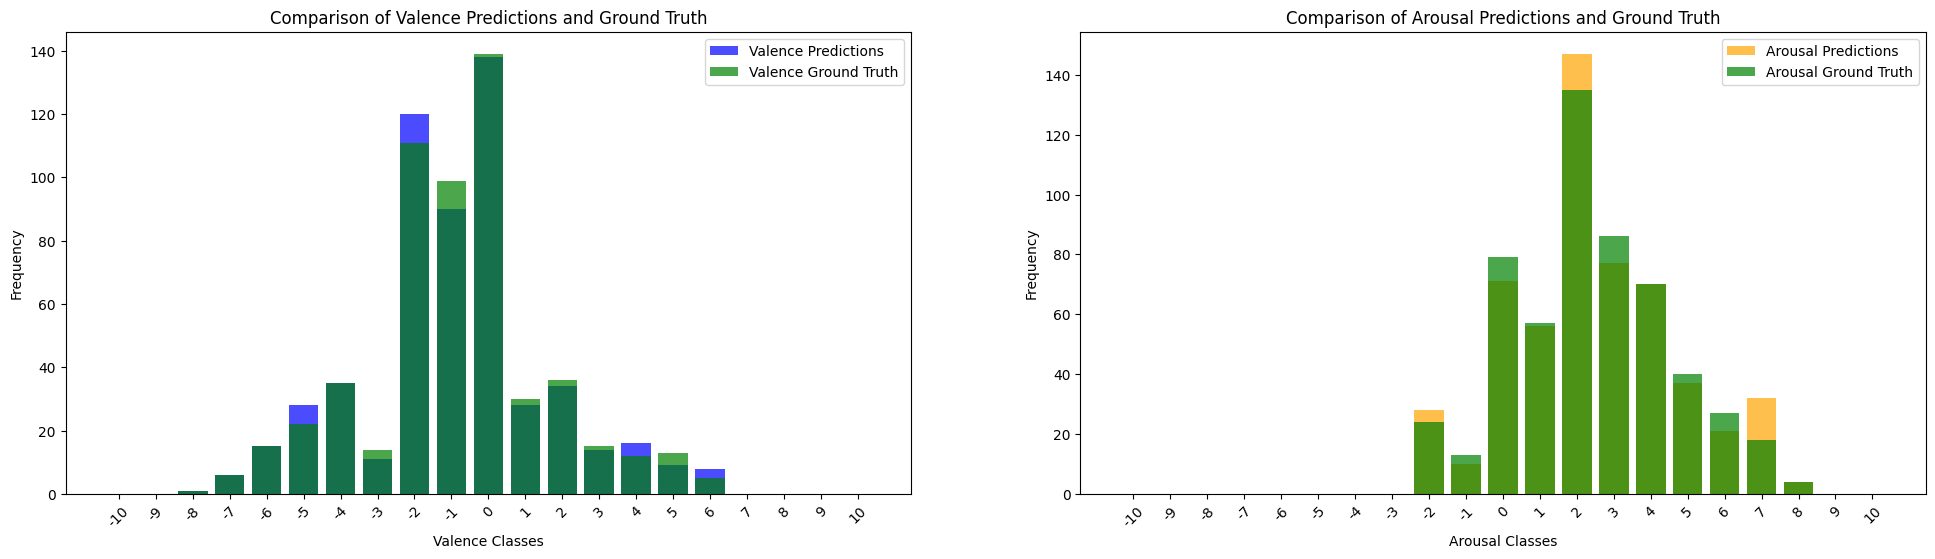

In [110]:
def plot_histograms(valence_predictions, valence_ground_truth, arousal_predictions, arousal_ground_truth, class_names):
    # Define bins for the histogram based on the class names provided
    bins = np.arange(min(class_names) - 0.5, max(class_names) + 1.5)

    # Setup the figure and subplots
    plt.figure(figsize=(24, 6))  # Wider figure to accommodate two subplots

    # Plot for Valence
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.hist(valence_predictions, bins, alpha=0.7, label='Valence Predictions', color='blue', rwidth=0.8)
    plt.hist(valence_ground_truth, bins, alpha=0.7, label='Valence Ground Truth', color='green', rwidth=0.8)
    plt.xlabel('Valence Classes')
    plt.ylabel('Frequency')
    plt.title('Comparison of Valence Predictions and Ground Truth')
    plt.xticks(ticks=np.arange(min(class_names), max(class_names)+1), labels=class_names, rotation=45)
    plt.legend()

    # Plot for Arousal
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.hist(arousal_predictions, bins, alpha=0.7, label='Arousal Predictions', color='orange', rwidth=0.8)
    plt.hist(arousal_ground_truth, bins, alpha=0.7, label='Arousal Ground Truth', color='green', rwidth=0.8)
    plt.xlabel('Arousal Classes')
    plt.ylabel('Frequency')
    plt.title('Comparison of Arousal Predictions and Ground Truth')
    plt.xticks(ticks=np.arange(min(class_names), max(class_names)+1), labels=class_names, rotation=45)
    plt.legend()

    plt.show()


print("True Arousal Labels:", true_arousal_labels)
print("True Valence Labels:", true_valence_labels)


class_names = list(range(-10, 11))  # Classes from -10 to 10 for both valence and arousal
valence_predictions = predictions_valence
valence_ground_truth = true_valence_labels
arousal_predictions = predictions_arousal
arousal_ground_truth = true_arousal_labels

plot_histograms(valence_predictions, valence_ground_truth, arousal_predictions, arousal_ground_truth, class_names)

In [108]:
f1_arousal = f1_score(true_arousal_labels, predictions_arousal, average='macro')
f1_valence = f1_score(true_valence_labels, predictions_valence, average='macro')
print(f'Arousal F1 Score: {f1_arousal}')
print(f'Valence F1 Score: {f1_valence}')

Arousal F1 Score: 0.8222648614710653
Valence F1 Score: 0.89378634413001


In [111]:
import numpy as np

arousal_predictions_np = np.array(arousal_predictions)
valence_predictions_np = np.array(valence_predictions)
true_arousal_labels_np = np.array(true_arousal_labels)
true_valence_labels_np = np.array(true_valence_labels)


In [112]:
np.save('/content/drive/MyDrive/Celestine/Sequence_based FER/arousal_predictions.npy', arousal_predictions_np)
np.save('/content/drive/MyDrive/Celestine/Sequence_based FER/valence_predictions.npy', valence_predictions_np)
np.save('/content/drive/MyDrive/Celestine/Sequence_based FER/true_arousal_labels.npy', true_arousal_labels_np)
np.save('/content/drive/MyDrive/Celestine/Sequence_based FER/true_valence_labels.npy', true_valence_labels_np)
